In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

In [2]:
# Load datasets
training_set_features = pd.read_csv('training_set_features.csv')
training_set_labels = pd.read_csv('training_set_labels.csv')
test_set_features = pd.read_csv('test_set_features.csv')

# Display missing values for training set features
missing_values_training_features = training_set_features.isnull().sum()

# Display missing values for training set labels
missing_values_training_labels = training_set_labels.isnull().sum()

# Display missing values for test set features
missing_values_test_features = test_set_features.isnull().sum()

# Print missing values
print("Missing values in training set features:")
print(missing_values_training_features[missing_values_training_features > 0])

print("\nMissing values in training set labels:")
print(missing_values_training_labels[missing_values_training_labels > 0])

print("\nMissing values in test set features:")
print(missing_values_test_features[missing_values_test_features > 0])


Missing values in training set features:
xyz_concern                       92
xyz_knowledge                    116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_xyz                 2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_xyz_vacc_effective       391
opinion_xyz_risk                 388
opinion_xyz_sick_from_vacc       395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
education                       1407
income_poverty                  4423
marital_status                  1408
rent_or_own                     2042
employment_status               14

In [3]:
# Impute missing values for numeric columns with median
numeric_cols = training_set_features.select_dtypes(include=['number']).columns
training_set_features[numeric_cols] = training_set_features[numeric_cols].fillna(training_set_features[numeric_cols].median())
test_set_features[numeric_cols] = test_set_features[numeric_cols].fillna(test_set_features[numeric_cols].median())

# Impute missing values for categorical columns with mode
categorical_cols = training_set_features.select_dtypes(include=['object']).columns
training_set_features[categorical_cols] = training_set_features[categorical_cols].fillna(training_set_features[categorical_cols].mode().iloc[0])
test_set_features[categorical_cols] = test_set_features[categorical_cols].fillna(test_set_features[categorical_cols].mode().iloc[0])

# Check if there are any remaining missing values
missing_values_training_features = training_set_features.isnull().sum().sum()
missing_values_test_features = test_set_features.isnull().sum().sum()

print(f"Total remaining missing values in training set features: {missing_values_training_features}")
print(f"Total remaining missing values in test set features: {missing_values_test_features}")

Total remaining missing values in training set features: 0
Total remaining missing values in test set features: 0


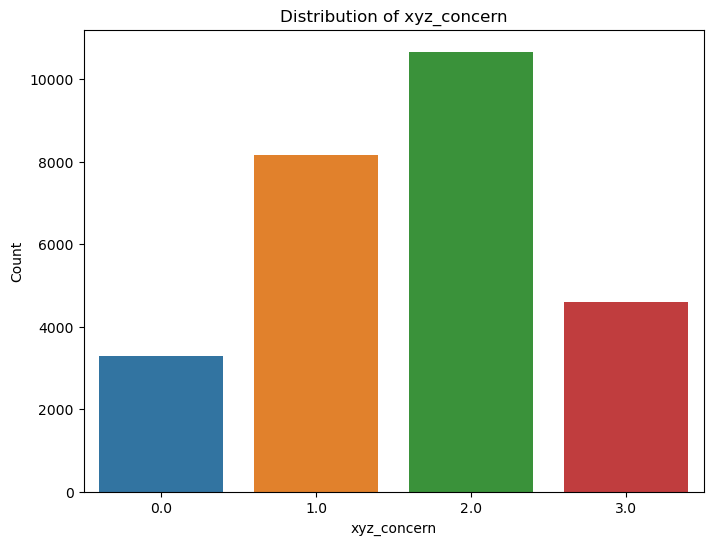

In [4]:
# Example: Distribution of xyz_concern
plt.figure(figsize=(8, 6))
sns.countplot(x='xyz_concern', data=training_set_features)
plt.title('Distribution of xyz_concern')
plt.xlabel('xyz_concern')
plt.ylabel('Count')
plt.show()

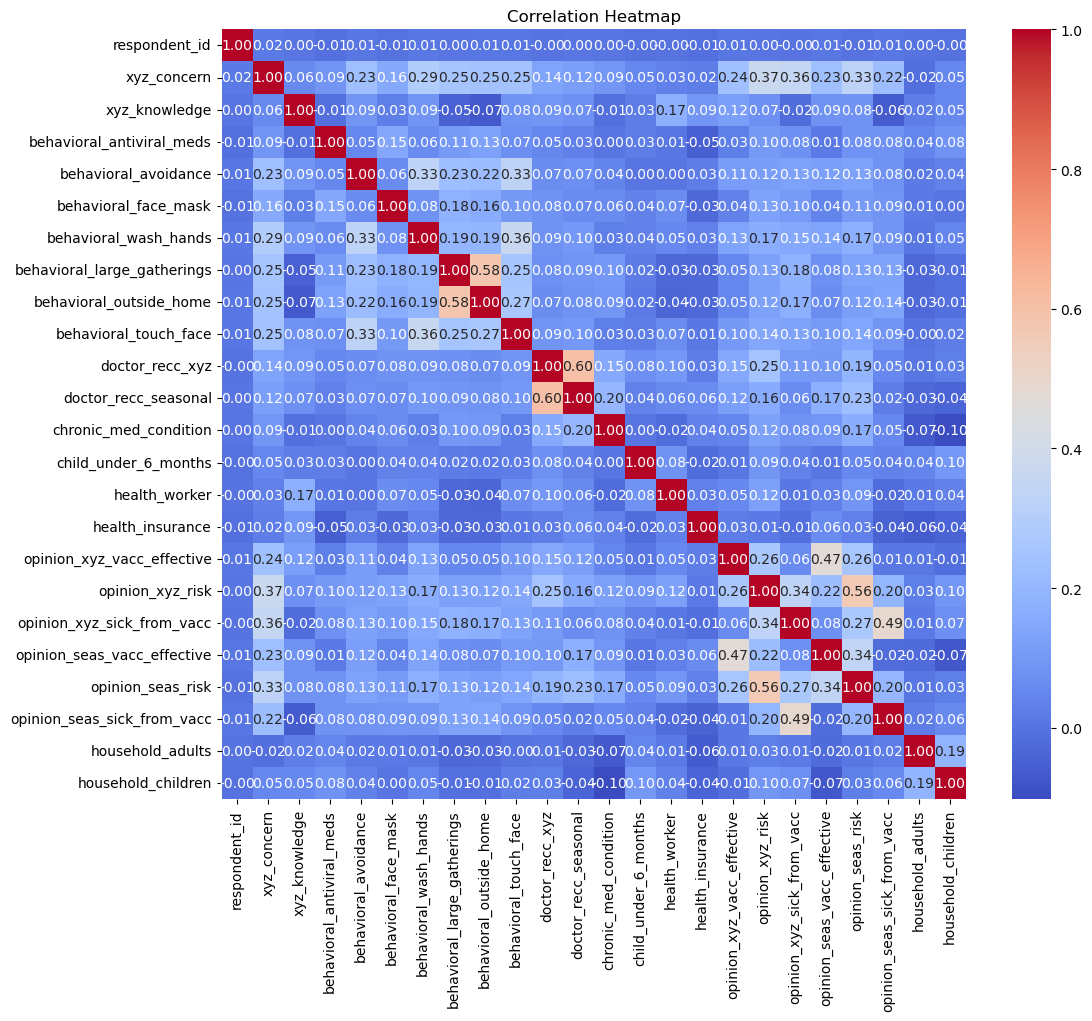

In [5]:
# Example: Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(training_set_features.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [6]:
# Display data types of training set features
print("Data types of training set features:")
print(training_set_features.dtypes)

# Display data types of training set labels
print("\nData types of training set labels:")
print(training_set_labels.dtypes)

# Display data types of test set features
print("\nData types of test set features:")
print(test_set_features.dtypes)

Data types of training set features:
respondent_id                    int64
xyz_concern                    float64
xyz_knowledge                  float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_xyz                float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_xyz_vacc_effective     float64
opinion_xyz_risk               float64
opinion_xyz_sick_from_vacc     float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                       

In [7]:
# Separate features and target variables
X_train = training_set_features.drop(columns=['respondent_id'])
y_train_xyz = training_set_labels['xyz_vaccine']
y_train_seasonal = training_set_labels['seasonal_vaccine']

X_test = test_set_features.drop(columns=['respondent_id'])

In [8]:
# Define categorical and numeric features
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X_train.select_dtypes(include=['number']).columns.tolist()

In [9]:
# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


In [10]:
# Models to evaluate
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42)
}

In [11]:
# Evaluation metrics storage
results = {}

In [12]:
# Iterate over models
for model_name, model in models.items():
    # Create pipeline with model and preprocessing
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    
    # Train model
    pipeline.fit(X_train, y_train_xyz)  # Example with xyz_vaccine, repeat for seasonal_vaccine if needed
    
    # Predict on validation set
    y_pred_proba = pipeline.predict_proba(X_train)[:, 1]
    
    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_train_xyz, y_pred_proba)
    
    # Store results
    results[model_name] = roc_auc

In [13]:
# Print results
print("ROC AUC scores:")
for model_name, roc_auc in results.items():
    print(f"{model_name}: {roc_auc}")

ROC AUC scores:
LogisticRegression: 0.8379054912131717
RandomForestClassifier: 1.0
GradientBoostingClassifier: 0.8492490550751935


In [14]:
# Choose the best model based on ROC AUC score and make predictions on test set
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

In [19]:
print(f"\nBest model based on ROC AUC score: {best_model_name}")
# Retrieve the best model object
best_model = models[best_model_name]


Best model based on ROC AUC score: RandomForestClassifier


In [29]:
# Models to evaluate
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42)
}

In [30]:
# Example for RandomForestClassifier
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20]
}

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(random_state=42))])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train_xyz)

print("Best parameters found:")
print(grid_search.best_params_)
print("Best ROC AUC score found:")
print(grid_search.best_score_)

Best parameters found:
{'classifier__max_depth': 20, 'classifier__n_estimators': 300}
Best ROC AUC score found:
0.8317542111421663


In [33]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define categorical and numeric features
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X_train.select_dtypes(include=['number']).columns.tolist()

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


In [34]:
# Add the classifier to the preprocessing pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', best_model)])  # best_model is RandomForestClassifier

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train_xyz)  # Training for xyz_vaccine, repeat similarly for seasonal_vaccine if needed

# Predict probabilities for the test set
y_pred_proba_xyz = pipeline.predict_proba(X_test)[:, 1]

In [36]:
print("Length of respondent_id:", len(test_set_features['respondent_id']))
print("Length of y_pred_proba_xyz:", len(y_pred_proba_xyz))
print("Length of y_pred_proba_seasonal:", len(y_pred_proba_seasonal))


Length of respondent_id: 26708
Length of y_pred_proba_xyz: 26708
Length of y_pred_proba_seasonal: 26707


In [37]:
# Assuming pipeline and models are defined as before

# Fit pipeline for xyz_vaccine
pipeline.fit(X_train, y_train_xyz)
y_pred_proba_xyz = pipeline.predict_proba(X_test)[:, 1]

# Fit pipeline for seasonal_vaccine (assuming the same pipeline)
pipeline.fit(X_train, y_train_seasonal)
y_pred_proba_seasonal = pipeline.predict_proba(X_test)[:, 1]

# Check lengths
print("Length of respondent_id:", len(test_set_features['respondent_id']))
print("Length of y_pred_proba_xyz:", len(y_pred_proba_xyz))
print("Length of y_pred_proba_seasonal:", len(y_pred_proba_seasonal))


Length of respondent_id: 26708
Length of y_pred_proba_xyz: 26708
Length of y_pred_proba_seasonal: 26708


In [40]:
# Assuming test_set_features is already loaded and preprocessed

# Create submission DataFrame
submission = pd.DataFrame({
    'respondent_id': test_set_features['respondent_id'],
    'h1n1_vaccine': y_pred_proba_xyz,
    'seasonal_vaccine': y_pred_proba_seasonal
})

# Save submission to CSV
submission.to_csv('submissions.csv', index=False)